In [6]:
import xgboost as xgb
import awkward as ak
import matplotlib.pyplot as plt
import hist
import warnings
import pickle
from sklearn.metrics import roc_curve, auc
import math
import os
import uproot
import json
import numpy as np

In [7]:
warnings.filterwarnings('ignore', 'invalid value')
warnings.filterwarnings('ignore', 'No format')
warnings.filterwarnings('ignore', 'overflow encountered in exp')

In [8]:
mc = ak.from_parquet('/scratch365/cmoore24/training/hgg/ecf_vs_data/inputs/test/mc.parquet')
data = ak.from_parquet('/scratch365/cmoore24/training/hgg/ecf_vs_data/inputs/test/data.parquet')

In [10]:
ratios = 100

In [11]:
with open(f'/scratch365/cmoore24/training/hgg/batch2025/ml_results_check/sub_ratios/{ratios}.pkl', 'rb') as f:
    feature_names = pickle.load(f)
# feature_names = mc.fields

In [12]:
len(feature_names)

100

In [13]:
path = f'/scratch365/cmoore24/training/hgg/ecf_vs_data/bdt/output/{ratios}'

In [14]:
bst = xgb.Booster()
bst.load_model(f'{path}/bdt_model.json')

In [15]:
scaler = f'{path}/scaler.pkl'
with open(scaler, 'rb') as f:
    scaler = pickle.load(f)

In [16]:
mc_np = np.column_stack([ak.to_numpy(mc[feature]) for feature in feature_names])
data_np = np.column_stack([ak.to_numpy(data[feature]) for feature in feature_names])

In [17]:
mc_np = scaler.transform(mc_np)
data_np = scaler.transform(data_np)

In [18]:
mc_xgb = xgb.DMatrix(mc_np, feature_names=feature_names)
data_xgb = xgb.DMatrix(data_np, feature_names=feature_names)

In [19]:
mc['mc_scores'] = bst.predict(mc_xgb)
data['data_scores'] = bst.predict(data_xgb)

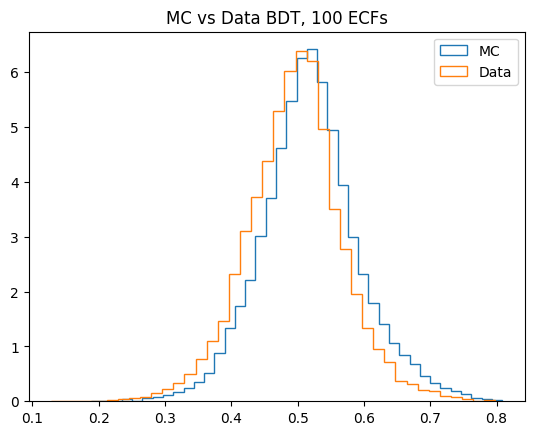

In [20]:
plt.hist(mc.mc_scores, bins=40, histtype='step', label='MC', density=True)
plt.hist(data.data_scores, bins=40, histtype='step', label='Data', density=True)
plt.title(f'MC vs Data BDT, {ratios} ECFs')
plt.legend()
plt.show()

In [15]:
mask = ~np.isnan(data.data_scores)
data_scores = data.data_scores[mask]# & (qcd_scores > -6) & (qcd_scores < 6)]
data_train = data[mask]

In [16]:
mask = ~np.isnan(mc.mc_scores)
mc_scores = mc.mc_scores[mask]# & (hgg_scores > -6) & (hgg_scores < 6)]
mc_train = mc[mask]

In [17]:
bkg_zeros = ak.zeros_like(data.data_scores)
sig_ones = ak.ones_like(mc.mc_scores)
combined = ak.concatenate([data.data_scores,mc.mc_scores])
combined_truth = ak.concatenate([bkg_zeros, sig_ones])

In [18]:
fpr, tpr, thresholds = roc_curve(combined_truth, combined)
roc_auc = auc(fpr, tpr)

In [19]:
hrange=(np.floor(ak.min(mc.mc_scores)), np.ceil(ak.max(mc.mc_scores)))

In [20]:
mc_hist = np.histogram(mc_scores, bins=10,
                range=hrange
                )
data_hist = np.histogram(data_scores, bins=10, 
                 range=hrange
                )

In [21]:
sig_sums = []
for i in range(len(mc_hist[0])+1):
    sig_sums.append(sum(mc_hist[0][len(mc_hist[0])-i:]))

bkg_sums = []
for i in range(len(data_hist[0])+1):
    bkg_sums.append(sum(data_hist[0][len(data_hist[0])-i:]))

In [22]:
sig_ratios = []
for i in sig_sums:
    sig_ratios.append(i/sig_sums[-1])
bkg_ratios = []
for i in bkg_sums:
    bkg_ratios.append(i/bkg_sums[-1])

In [23]:
wp_ratios = {}
for i in range(len(mc_hist[1])):
    wp_ratios[str(mc_hist[1][-i-1])] = [sig_ratios[i], bkg_ratios[i]]

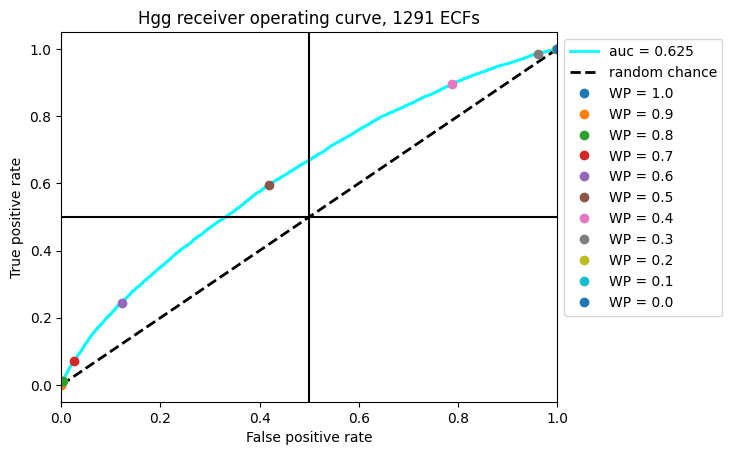

In [24]:
plt.plot(fpr, tpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle="--", lw=2, color="k", label="random chance")
plt.xlim([0, 1.0])
#     ax.set_ylim([1e-5, 1.0])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title(f"Hgg receiver operating curve, {ratios} ECFs")
plt.legend(loc="lower right")
plt.axvline(x=0.5, color='black')
plt.axhline(y=0.5, color='black')
for i in wp_ratios:
    plt.plot(wp_ratios[i][1], wp_ratios[i][0], 'o', label=f'WP = {float(i):.1f}')
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(f'rocs/{ratios}.png', bbox_inches='tight')
plt.show()

In [25]:
output = {}
output['fpr'] = fpr.tolist()
output['tpr'] = tpr.tolist()
output['auc'] = roc_auc

In [26]:
# with open(f'roc_jsons/{ratios}.json', 'w') as f:
#     json.dump(output, f)

In [27]:
feature_strength = bst.get_score(importance_type="gain")
feature_strength_full = {f: feature_strength.get(f, 0.0) for f in feature_names}

In [28]:
sorted_by_values = dict(sorted(feature_strength_full.items(), key=lambda item: item[1]))

In [302]:
# with open('strength_jsons/data_vs_mc_strengths_75.json', 'w') as f:
#     json.dump(feature_strength_full, f)